In [1]:
import os
from keys import OPENAI_API_KEY, ACTIVELOOP_TOKEN
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
os.environ["ACTIVELOOP_TOKEN"] = ACTIVELOOP_TOKEN

## YouTube Video Summarizer

### Flow Diagram

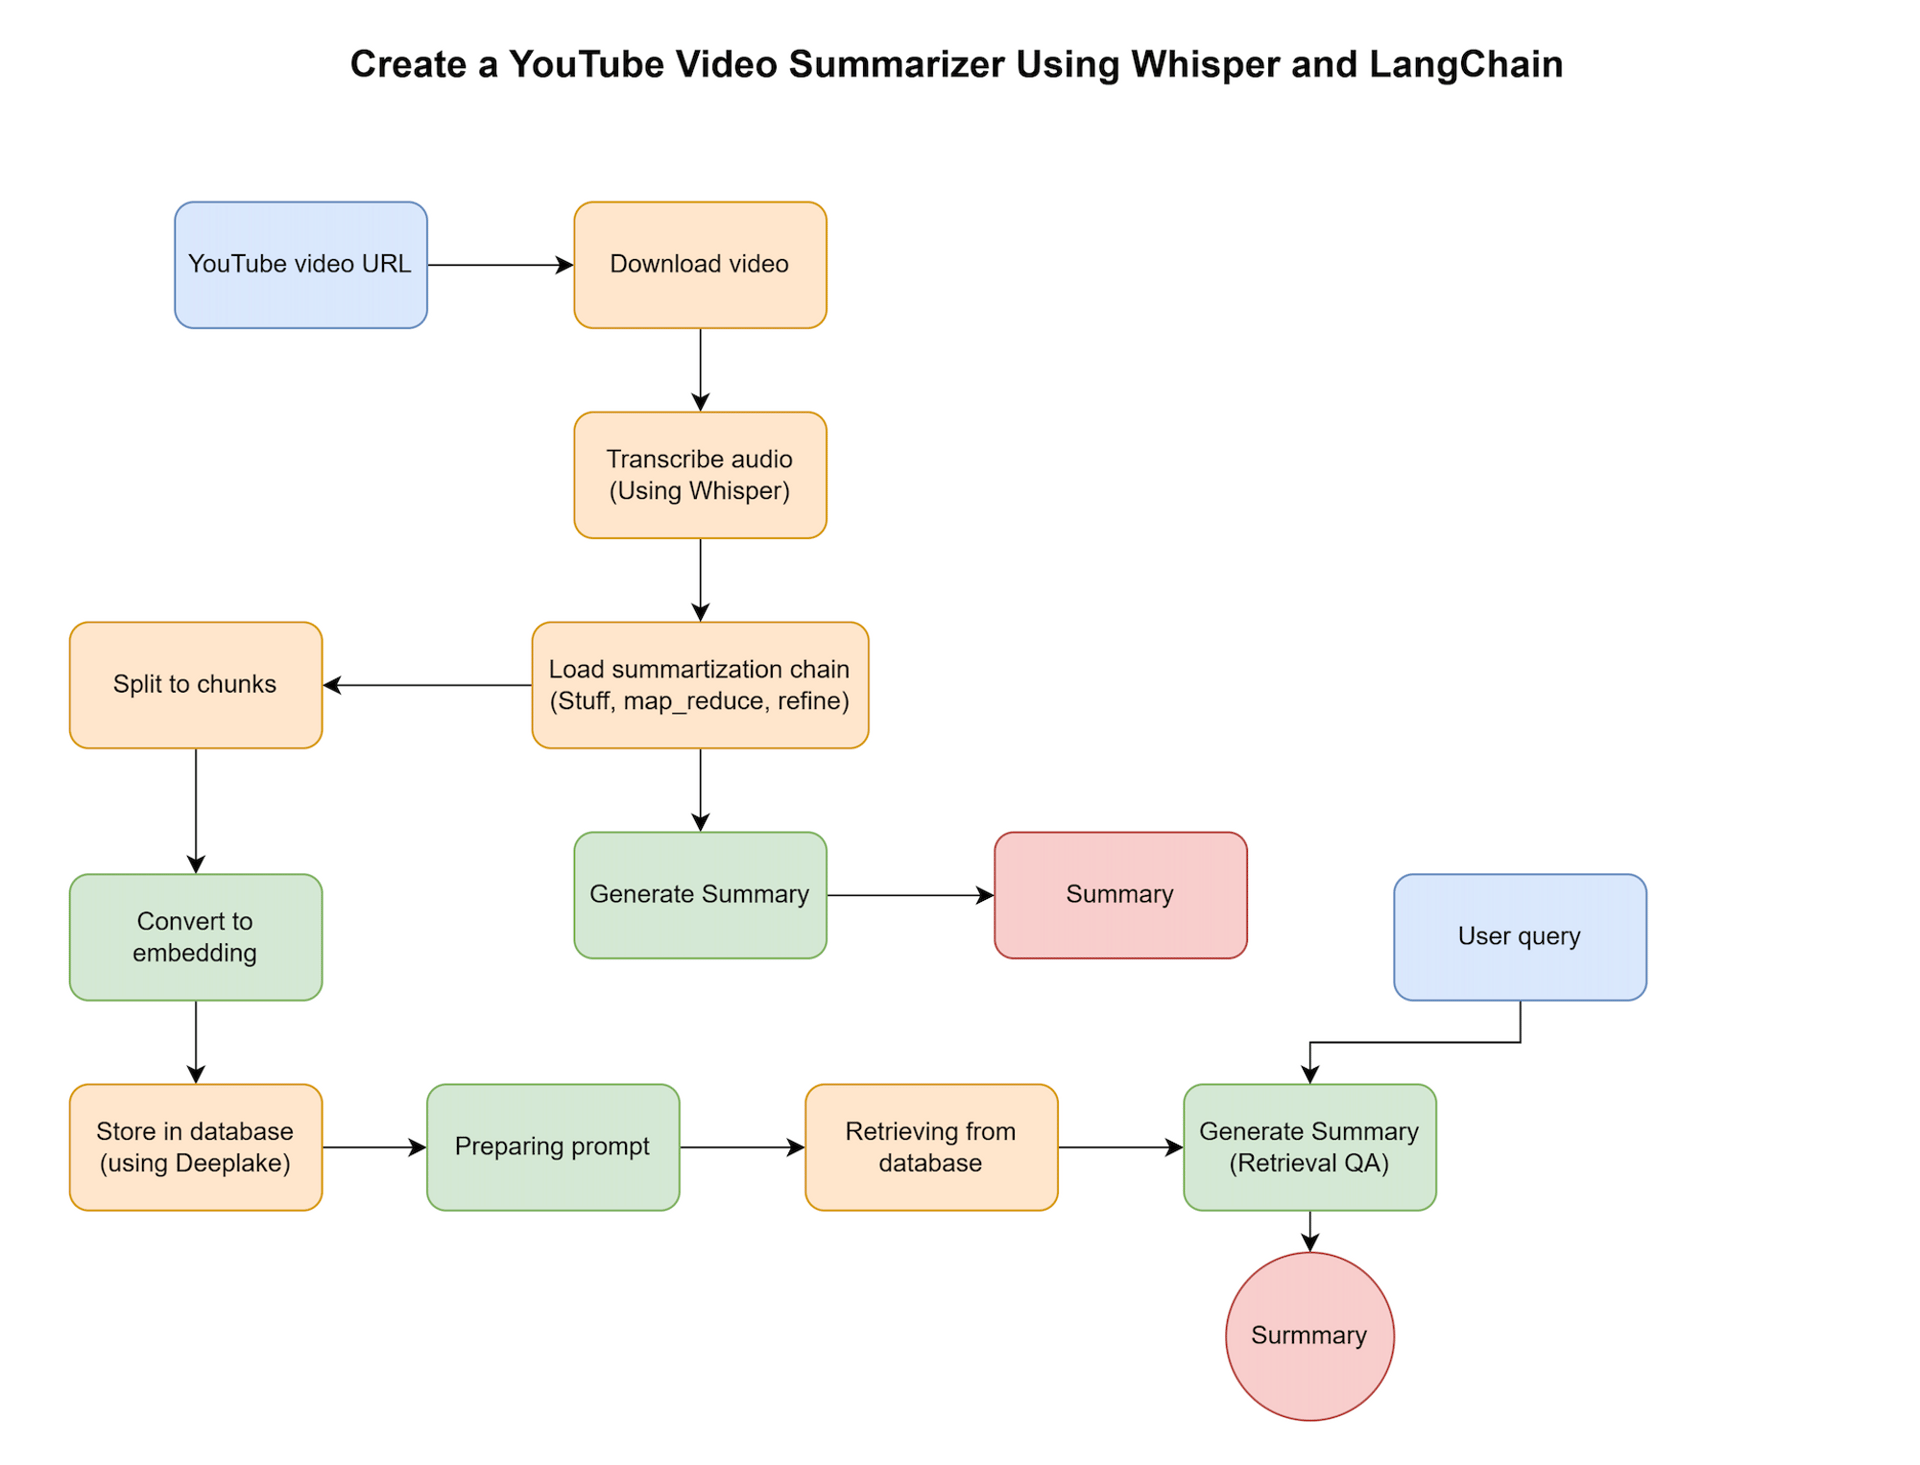

In [1]:
from PIL import Image
from io import BytesIO
from IPython.display import display
import requests

img_url = 'https://images.spr.so/cdn-cgi/imagedelivery/j42No7y-dcokJuNgXeA0ig/68ffb8d3-4c01-4d8f-a56c-4b52095bf860/Screenshot_2023-06-09_at_13.48.43/w=1920,quality=80'
res = requests.get(img_url, stream=True)
img = Image.open(BytesIO(res.content))
display(img)

### Transcribing the Video

In [9]:
import yt_dlp

def download_mp4_from_youtube(url):
    # Set the options for the download
    filename = 'lecuninterview.mp4'
    ydl_opts = {
        'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/best[ext=mp4]',
        'outtmpl': filename,
        'quiet': True,
    }

    # Download the video file
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        result = ydl.extract_info(url, download=True)

url = "https://www.youtube.com/watch?v=mBjPyte2ZZo"
download_mp4_from_youtube(url)

In [3]:
import whisper

model = whisper.load_model("base")
result = model.transcribe("lecuninterview.mp4")
print(result['text'])

/home/bharat/mambaforge/envs/llm-env/lib/python3.11/site-packages/whisper/timing.py:57: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit
/home/bharat/mambaforge/envs/llm-env/lib/python3.11/site-packages/whisper/transcribe.py:114: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


 Hi, I'm Craig Smith and this is I on A On. This week I talked to Jan LeCoon, one of the seminal figures in deep learning development and a long time proponent of self-supervised learning. Jan spoke about what's missing in large language models and about his new joint embedding predictive architecture which may be a step toward filling that gap. He also talked about his theory of consciousness and the potential for AI systems to someday exhibit the features of consciousness. It's a fascinating conversation that I hope you'll enjoy. Okay, so Jan, it's great to see you again. I wanted to talk to you about where you've gone with so supervised learning since last week spoke. In particular, I'm interested in how it relates to large language models because the large language models really came on stream since we spoke. In fact, in your talk about JEPA, which is joint embedding predictive architecture. There you go. Thank you. You mentioned that large language models lack a world model. I wan

In [4]:
with open ('video_text.txt', 'w') as file:  
    file.write(result['text'])

### Summarization with LangChain

In [5]:
from langchain import OpenAI, LLMChain
from langchain.chains.mapreduce import MapReduceChain
from langchain.prompts import PromptTemplate
from langchain.chains.summarize import load_summarize_chain

llm = OpenAI(model_name="text-davinci-003", temperature=0)

In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=0, separators=[" ", ",", "\n"]
)

In [8]:
from langchain.docstore.document import Document

with open('video_text.txt') as f:
    text = f.read()

texts = text_splitter.split_text(text)
docs = [Document(page_content=t) for t in texts[:4]]

In [9]:
from langchain.chains.summarize import load_summarize_chain
import textwrap

chain = load_summarize_chain(llm, chain_type="map_reduce")

output_summary = chain.run(docs)
wrapped_text = textwrap.fill(output_summary, width=100)
print(wrapped_text)

 Craig Smith interviews Jan LeCoon, a deep learning developer and proponent of self-supervised
learning, about his new joint embedding predictive architecture and his theory of consciousness.
Jan's research focuses on self-supervised learning, which has revolutionized natural language
processing, and his latest paper is the Joint Embedding Predictive Architecture. Self-supervised
learning is a technique used to train large neural networks to predict missing words in a piece of
text, and generative models are used to predict missing words in a text, but it is difficult to
represent uncertain predictions.


In [10]:
print( chain.llm_chain.prompt.template )

Write a concise summary of the following:


"{text}"


CONCISE SUMMARY:


In [11]:
prompt_template = """Write a concise bullet point summary of the following:


{text}


CONSCISE SUMMARY IN BULLET POINTS:"""

BULLET_POINT_PROMPT = PromptTemplate(template=prompt_template, 
                        input_variables=["text"])

In [12]:
chain = load_summarize_chain(llm, 
                             chain_type="stuff", 
                             prompt=BULLET_POINT_PROMPT)

output_summary = chain.run(docs)

wrapped_text = textwrap.fill(output_summary, 
                             width=1000,
                             break_long_words=False,
                             replace_whitespace=False)
print(wrapped_text)


- Jan LeCoon is a seminal figure in deep learning development and a long time proponent of self-supervised learning
- Discussed his new joint embedding predictive architecture which may be a step toward filling the gap in large language models
- Theory of consciousness and potential for AI systems to exhibit features of consciousness
- Self-supervised learning revolutionized natural language processing
- Large language models lack a world model and are generative models, making it difficult to represent uncertain predictions


In [ ]:
chain = load_summarize_chain(llm, chain_type="refine")

output_summary = chain.run(docs)
wrapped_text = textwrap.fill(output_summary, width=100)
print(wrapped_text)

### Add Transcripts to Vector DB

In [16]:
import yt_dlp

def download_mp4_from_youtube(urls, job_id):
    # This will hold the titles and authors of each downloaded video
    video_info = []

    for i, url in enumerate(urls):
        # Set the options for the download
        file_temp = f'./{job_id}_{i}.mp4'
        ydl_opts = {
            'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/best[ext=mp4]',
            'outtmpl': file_temp,
            'quiet': True,
        }

        # Download the video file
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            result = ydl.extract_info(url, download=True)
            title = result.get('title', "")
            author = result.get('uploader', "")

        # Add the title and author to our list
        video_info.append((file_temp, title, author))

    return video_info

urls=["https://www.youtube.com/watch?v=mBjPyte2ZZo&t=78s",
    "https://www.youtube.com/watch?v=cjs7QKJNVYM",]
vides_details = download_mp4_from_youtube(urls, 1)

In [17]:
import whisper

# load the model
model = whisper.load_model("base")

# iterate through each video and transcribe
results = []
for video in vides_details:
    result = model.transcribe(video[0])
    results.append( result['text'] )
    print(f"Transcription for {video[0]}:\n{result['text']}\n")

with open ('text.txt', 'w') as file:  
    file.write(results['text'])

/home/bharat/mambaforge/envs/llm-env/lib/python3.11/site-packages/whisper/transcribe.py:114: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcription for ./1_0.mp4:
 Hi, I'm Craig Smith and this is I on A On. This week I talked to Jan LeCoon, one of the seminal figures in deep learning development and a long time proponent of self-supervised learning. Jan spoke about what's missing in large language models and about his new joint embedding predictive architecture which may be a step toward filling that gap. He also talked about his theory of consciousness and the potential for AI systems to someday exhibit the features of consciousness. It's a fascinating conversation that I hope you'll enjoy. Okay, so Jan, it's great to see you again. I wanted to talk to you about where you've gone with so supervised learning since last week spoke. In particular, I'm interested in how it relates to large language models because the large language models really came on stream since we spoke. In fact, in your talk about JEPA, which is joint embedding predictive architecture. There you go. Thank you. You mentioned that large language mod

/home/bharat/mambaforge/envs/llm-env/lib/python3.11/site-packages/whisper/transcribe.py:114: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcription for ./1_1.mp4:
 Hello, it's Yannick from the future. AI is moving crazy fast right now, like crazy. So the news of this week is like old news, but I'm still going to show to you. Google I.O. just recently happened. The gist of it is they're going to stick generative AI into just about everything. And also, Anthropic releases upgrades the Claude API to have a hundred thousand tokens context. No one knows so far how they're doing it, but it's happening. A hundred thousand tokens context insane. All right, enjoy the news. Yay. Jeff Hinton leaves Google and tells the world about the dangers of AI. Open AI loses half a billion dollars and Google has no mouth. Welcome to ML News. Hello, everyone. Welcome to ML News. Let's dive right in lots of stuff happening. This is Snapchat AI. Do you have access to my location? No, I don't have access to your location. Where am I? I'm sorry, but I don't have access to your location information. Okay, are you lying? No, I'm not lying. I don'

TypeError: list indices must be integers or slices, not str

In [18]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Load the texts
with open('text.txt') as f:
    text = f.read()
texts = text_splitter.split_text(text)

# Split the documents
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=0, separators=[" ", ",", "\n"]
    )
texts = text_splitter.split_text(text)

In [19]:
from langchain.docstore.document import Document

docs = [Document(page_content=t) for t in texts[:4]]

In [20]:
from langchain.vectorstores import DeepLake
from langchain.embeddings.openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model='text-embedding-ada-002')

# create Deep Lake dataset
# TODO: use your organization id here. (by default, org id is your username)
my_activeloop_org_id = "bharatr"
my_activeloop_dataset_name = "langchain_course_youtube_summarizer"
dataset_path = f"hub://{my_activeloop_org_id}/{my_activeloop_dataset_name}"

db = DeepLake(dataset_path=dataset_path, embedding_function=embeddings)
db.add_documents(docs)

Your Deep Lake dataset has been successfully created!


/

Dataset(path='hub://bharatr/langchain_course_youtube_summarizer', tensors=['embedding', 'id', 'metadata', 'text'])

  tensor      htype      shape     dtype  compression
  -------    -------    -------   -------  ------- 
 embedding  embedding  (4, 1536)  float32   None   
    id        text      (4, 1)      str     None   
 metadata     json      (4, 1)      str     None   
   text       text      (4, 1)      str     None   


['ff0b6938-3a79-11ee-a4d8-78af089a20b3',
 'ff0b6a0a-3a79-11ee-a4d8-78af089a20b3',
 'ff0b6a3c-3a79-11ee-a4d8-78af089a20b3',
 'ff0b6a5a-3a79-11ee-a4d8-78af089a20b3']

In [21]:
retriever = db.as_retriever()
retriever.search_kwargs['distance_metric'] = 'cos'
retriever.search_kwargs['k'] = 4

In [22]:
from langchain.prompts import PromptTemplate
prompt_template = """Use the following pieces of transcripts from a video to answer the question in bullet points and summarized. If you don't know the answer, just say that you don't know, don't try to make up an answer.

{context}

Question: {question}
Summarized answer in bullter points:"""
PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["context", "question"]
)

In [23]:
from langchain.chains import RetrievalQA

chain_type_kwargs = {"prompt": PROMPT}
qa = RetrievalQA.from_chain_type(llm=llm,
                                 chain_type="stuff",
                                 retriever=retriever,
                                 chain_type_kwargs=chain_type_kwargs)

print( qa.run("Summarize the mentions of google according to their AI program") )


- Google uses self-supervised learning to pre-train transformer architectures for natural language processing
- Google uses these transformer architectures to predict the next word in a text, allowing them to generate text spontaneously
- Google's AI program is used for contact moderation systems on their platforms
